# Notebook for Manifolder

Demonstration of the manifold reconstruction technique, using test data and space weather data.

The `simplified_data.csv` contains 8 channels of timeseries test data.  For simplicity, only the first channel contains the test signal, which contains a few different, repeating signal types.  All channels have low-level noise added, for numerical stability.

Running the `Manifolder` code with `Dim=3` projects the signal into an an underlying 3-dimensional manifold.  Plotting the signal, along with the underlying dimensions, gives a simple visual representation of the technique.

### Resources

[NumPy for Matlab users — NumPy v1.13 Manual](https://docs.scipy.org/doc/numpy-1.13.0/user/numpy-for-matlab-users.html)

[Getting Started with MATLAB](https://www.mathworks.com/help/matlab/getting-started-with-matlab.html)

In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

import pandas as pd

import time

### Run Manifolder, on Test Data

Run the code, using the sklearn-like interface, on sample data and solar wind data

In [10]:
#import sys
#sys.path.append(r"your\path\here")

import manifolder as mr
from manifolder import helper as mh


testing data a list of matrices
loaded data/simple_data.csv, shape: 3
calculating histograms for snip  0  of  3  (dim  8  timeseries) ........ done
calculating histograms for snip  1  of  3  (dim  8  timeseries) ........ done
calculating histograms for snip  2  of  3  (dim  8  timeseries) ........ done
computing local covariances for snip  0  of  3.......... done
computing local covariances for snip  1  of  3.......... done
computing local covariances for snip  2  of  3.......... done
using 4000 for variable m
computing Dis matrix ..........done!
aniostropic kernel ... Using partial symmetric eigensolver from scipy
done
extending embedding (building Psi) ... done
running k-means
(4200,)
normalizing amplitudes of Psi in Python ...
(4174,)
done


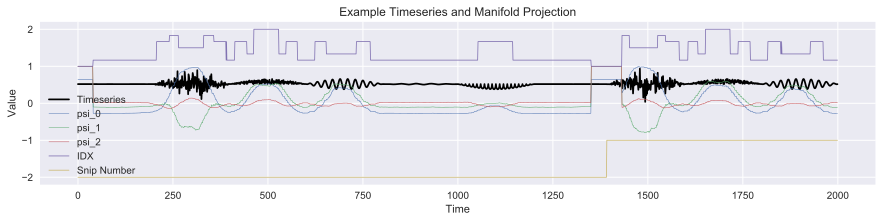

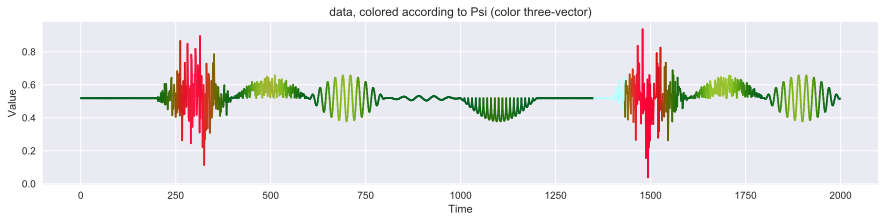


	 Program Executed in 50.49 seconds


In [15]:
# run the manifolder ... note, all functions are currently executed
# by the fit_transform() function, which is the equivalent of calling
#
#        manifolder._load_data(X)
#        manifolder._histograms_overlap()
#        manifolder._covariances()
#        manifolder._embedding()
#        manifolder._clustering()
#

start_time = time.time()

# load the data
data_location = 'data/simple_data.csv'
df = pd.read_csv(data_location, header=None)

test_snippets = True

if test_snippets:
    # test running "snippets" of the time series, by passing in
    # chunks of data as a list
    # Example as several snippets of time series
    print('testing data a list of matrices')
    z = [df.values[0:7000, :]]
    z.append(df.values[7001:14000, :])
    z.append(df.values[14001:21000, :])
    print('loaded', data_location + ', shape:', len(z))

else:
    # this would be the standard way of running the code,
    # if you have one continous series of data
    print('testing data as a single matrix')
    z = df.values
    print('loaded', data_location + ', shape:', z.shape)

# create manifolder object
manifolder = mr.Manifolder()

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(z)

manifolder._clustering()  # display

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


In [4]:
# IDX contains the index of clusters (typically ~7) ...
# need to make a dictionary, with a key for each index (0 to 6),
# the value is a list of the collection of lengths

cluster names (keys) [0 1 2 3 4 5 6]


<Figure size 432x288 with 0 Axes>

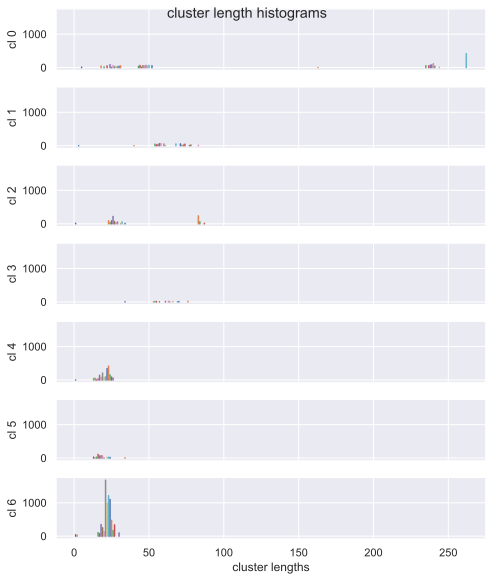

In [5]:
# clustering data ...

IDX = manifolder.IDX

cluster_lens = mh.count_cluster_lengths(IDX)

# cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# and the values are a list of clusner lengths

mh.show_cluster_lens(cluster_lens)


### Graph Transition (Markov) Matrix

The system can be though of as in one particular "state" (cluster value) at any given time.  This state $S$ can be though of as a column vector with $C$ dimensions, similar to states in quantum mechanic, where the column vector plays the role of the transition matrix.

Time evolution is this given by the tranistion matrix $M$, which is a Markov matrix (all columns sum to one, to preserve probability).  In this case, we have

$$
S_{n+1} = M @ S_n 
$$

Where the $@$ symbol is used to explicitly denote matrix multiplication.

Since most clusters with transition to themselves, the diagonal values of the matrix can be quite high, and are typically removed.  Thus, for visualization, we remove the diagonal elements of the matrix.

In [6]:
# in this case, index goes from 0 to 6 ...
# can also have outlier groups in kmeans, need to check for this

print(IDX.shape)
print(np.min(IDX))
print(np.max(IDX))

IDX_max = np.max(IDX)


(17524,)
0
6


In [7]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)



 transition matrix:
[[8216.    1.    0.    0.    0.    0.   59.]
 [   0. 1942.    0.    0.   31.    0.    0.]
 [   0.    0. 1928.    0.    0.   15.   30.]
 [   0.    0.    0.  892.    0.   15.    0.]
 [   0.   30.    0.    0. 1160.    0.   30.]
 [   0.    0.   15.   15.    0.  517.    0.]
 [  60.    0.   30.    0.   29.    0. 2508.]]


NOTE, need to fix bug, sometimes orders backwards

 transition matrix, ordered:
[[8216.   59.    1.    0.    0.    0.    0.]
 [  60. 2508.    0.   30.   29.    0.    0.]
 [   0.    0. 1942.    0.   31.    0.    0.]
 [   0.   30.    0. 1928.    0.    0.   15.]
 [   0.   30.   30.    0. 1160.    0.    0.]
 [   0.    0.    0.    0.    0.  892.   15.]
 [   0.    0.    0.   15.    0.   15.  517.]]


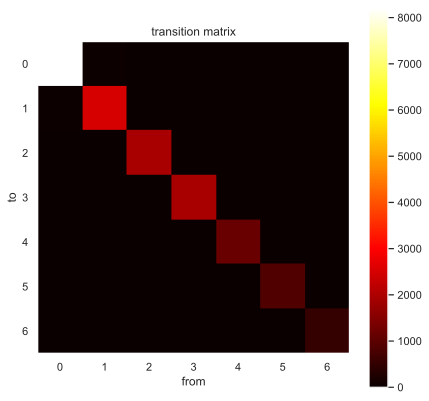

In [8]:
# reorder transition matrix, from most to least common cluster
# diagonal elements monotonically decreasing

IDX_ordered = mh.reorder_cluster(IDX, M)

M = mh.make_transition_matrix(IDX_ordered)
print('\n transition matrix, ordered:')
print(M)

mh.image_M(M)


transition matrix, diagonal elements removed, normalized (Markov)
[[0.     0.4958 0.0323 0.     0.     0.     0.    ]
 [1.     0.     0.     0.6667 0.4833 0.     0.    ]
 [0.     0.     0.     0.     0.5167 0.     0.    ]
 [0.     0.2521 0.     0.     0.     0.     0.5   ]
 [0.     0.2521 0.9677 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.5   ]
 [0.     0.     0.     0.3333 0.     1.     0.    ]]


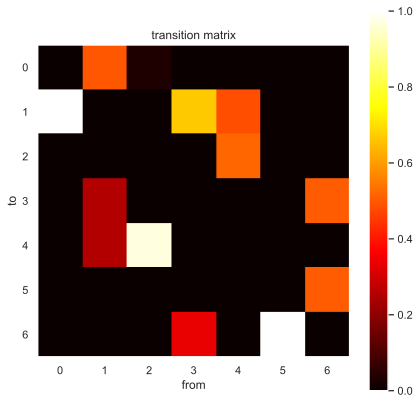

In [9]:
# remove diagonal, and make markov, for display

print('transition matrix, diagonal elements removed, normalized (Markov)')

np.fill_diagonal(M, 0)  # happens inplace
M = mh.make_matrix_markov(M)

print(M)
mh.image_M(M, 1)


### Run code again, on solar wind

loaded data/solar_wind_data.csv, shape: (87660, 8)
calculating histograms for 8 dimensions (univariate timeseries) ........ done
computing local covariances .......... done
using 4000 for variable m
computing Dis matrix ..........done!
aniostropic kernel ... done
extending embedding (building Psi) ... done
running k-means
(17532,)
normalizing amplitudes of Psi in Python ...
(17524,)
done


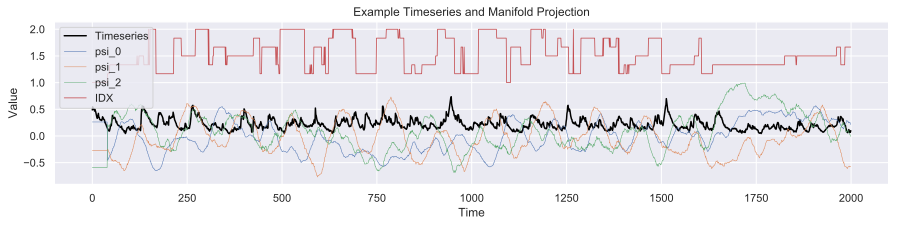

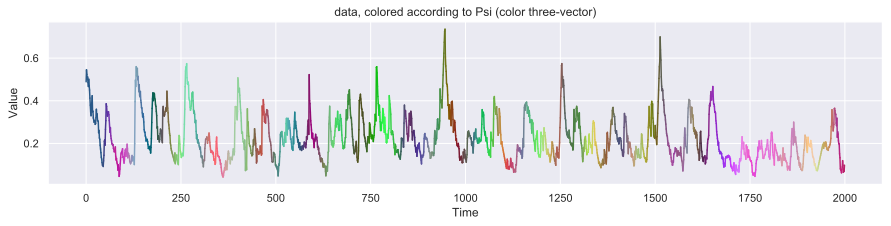


	 Program Executed in 241.99 seconds


In [10]:
start_time = time.time()

# load the data
data_location = 'data/solar_wind_data.csv'
df = pd.read_csv(data_location, header=None)
z = df.values
print('loaded', data_location + ', shape:', z.shape)

# create manifolder object
manifolder = mr.Manifolder()

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(z)

manifolder._clustering()  # display

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)
 

cluster names (keys) [0 1 2 3 4 5 6]


<Figure size 432x288 with 0 Axes>

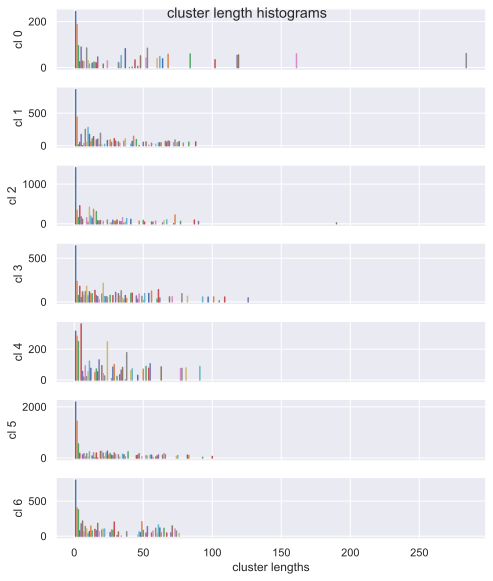

In [11]:
# clustering data ...

IDX = manifolder.IDX

cluster_lens = mh.count_cluster_lengths(IDX)

# cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# and the values are a list of clusner lengths

mh.show_cluster_lens(cluster_lens, sharey=False)


In [12]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)



 transition matrix:
[[1929.    0.    0.   16.   20.   25.    0.]
 [   1. 2521.   23.    0.   14.   36.   27.]
 [   0.   28. 2317.   25.   34.    5.   23.]
 [   9.    0.   34. 2830.   12.   31.   15.]
 [  27.   15.   22.   13. 1773.   11.    0.]
 [  24.   30.    6.   35.    8. 2760.   42.]
 [   0.   28.   30.   12.    0.   37. 2675.]]


NOTE, need to fix bug, sometimes orders backwards

 transition matrix, ordered:
[[2830.   31.   15.    0.   34.    9.   12.]
 [  35. 2760.   42.   30.    6.   24.    8.]
 [  12.   37. 2675.   28.   30.    0.    0.]
 [   0.   36.   27. 2521.   23.    1.   14.]
 [  25.    5.   23.   28. 2317.    0.   34.]
 [  16.   25.    0.    0.    0. 1929.   20.]
 [  13.   11.    0.   15.   22.   27. 1773.]]


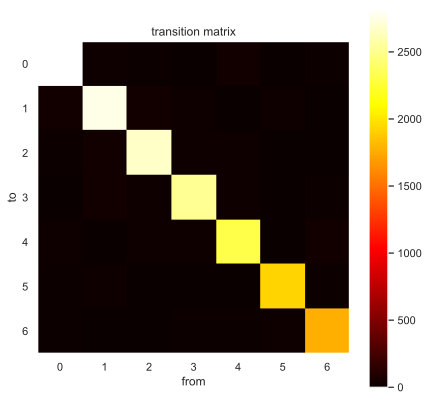

In [13]:
# reorder transition matrix, from most to least common cluster
# diagonal elements monotonically decreasing

IDX_ordered = mh.reorder_cluster(IDX, M)

M = mh.make_transition_matrix(IDX_ordered)
print('\n transition matrix, ordered:')
print(M)

mh.image_M(M)


transition matrix, diagonal elements removed, normalized (Markov)
[[0.     0.2138 0.1402 0.     0.2957 0.1475 0.1364]
 [0.3465 0.     0.3925 0.297  0.0522 0.3934 0.0909]
 [0.1188 0.2552 0.     0.2772 0.2609 0.     0.    ]
 [0.     0.2483 0.2523 0.     0.2    0.0164 0.1591]
 [0.2475 0.0345 0.215  0.2772 0.     0.     0.3864]
 [0.1584 0.1724 0.     0.     0.     0.     0.2273]
 [0.1287 0.0759 0.     0.1485 0.1913 0.4426 0.    ]]


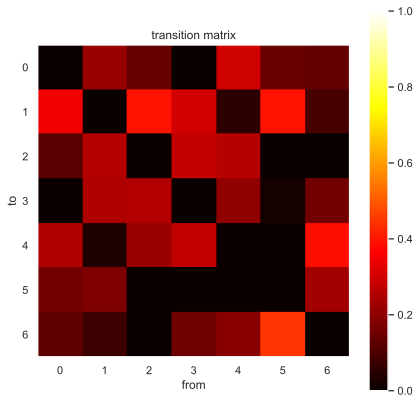

In [14]:
# remove diagonal, and make markov, for display

print('transition matrix, diagonal elements removed, normalized (Markov)')

np.fill_diagonal(M, 0)  # happens inplace
M = mh.make_matrix_markov(M)

print(M)
mh.image_M(M, 1)


### Packaging

In [15]:
#assert False, 'code stops here (experimental code below)'


In [16]:
# Inspect existing sklearn code, for structure

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

# https://leemendelowitz.github.io/blog/how-does-python-find-packages.html
import imp

imp.find_module('sklearn')
# (None, '/usr/local/lib/python2.7/dist-packages/numpy', ('', '', 5))

# this is how to interface with sklearn

import numpy as np
from sklearn.linear_model import LinearRegression

# think this brings in everything from the __init__.py?
import sklearn.linear_model as lm

X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
y = np.dot(X, np.array([1, 2])) + 3  # y = 1 * x_0 + 2 * x_1 + 3

reg = LinearRegression().fit(X, y)
print('reg.score(X,y)', reg.score(X, y))  # 1.0

reg.coef_
print('reg.coef_', reg.coef_)  # array([1., 2.])

reg.intercept_
# 3.0000...
reg.predict(np.array([[3, 5]]))
# array([16.])


reg.score(X,y) 1.0
reg.coef_ [1. 2.]


array([16.])

### tSNE

In [17]:
assert False, 'stop here'

AssertionError: stop here

In [ ]:
from sklearn.manifold import TSNE

X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
print('X.shape', X.shape)
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)


### Alterantive Custering Techniques

Look at 'null-set' clustering, as well as tSNE, and Manifolder

In [ ]:
# using a stepSize of 5 for the clustering;
# cut down to this size, to compare ... 
# note this drops points for the analysis (but use this as a startng point)
data_standard = z.T

data_standard = data_standard[::5, :]
print('data_standard.shape', data_standard.shape)

# data_standard = data_standard[:4000,:] # shorten more, so algos run faster
print('data_standard.shape', data_standard.shape)

# also, keep track of the manifolder data ... 
# since manifolder uses a stepSize of 5, do not downsample
# before passing the data in - output data is automatically downsampled ...
data_manifolder = z.T
# data_manifolder = data_manifolder[:4010*5,:]


In [ ]:
#
# loop through reconstruction techniques
#

from sklearn.manifold import TSNE

start_time = time.time()
techniques = ['null','tsne','manifolder']

for tech in techniques:
    print( '*** reconstructing using',tech)

    if tech == 'null':
        print('calculating for null (this fast!)')
        z_embedded_null = data_standard # no embedding, embedded is the same as data
        
    elif tech == 'tsne':
        print('calculating TSNE - this can take some time')
        
        z_embedded_tsne = TSNE(n_components=3).fit_transform(data_standard)

    elif tech == 'manifolder':
        print('calculating manifolder')
        manifolder = mr.Manifolder() 
        z_embedded_mani = manifolder.fit_transform(data_manifolder)
        
    else:
        assert False, 'technique not understood'

# cut this down to the same length - passed in data that was slightly too long
# z_embedded_mani = z_embedded_mani[:4000,:]

elapsed = time.time() - start_time
print('elapsed mins:', np.round(elapsed / 60, 2))


In [ ]:
print(z_embedded_null.shape)
print(data_standard.shape)

In [ ]:
from sklearn.cluster import KMeans

# cluster the values from tSNE ...
numClusters = 7

#kmeans = KMeans(n_clusters=numClusters).fit(z_embedded)
#IDX = kmeans.labels_


In [ ]:
def display_embedding( data, embedding ):
    print(  'data.shape',data.shape,'embedding.shape[0]',embedding.shape[0] )
    assert data.shape[0] == embedding.shape[0], 'data and must have same length'
    
    # Configuration
    numClusters = 7         
    intrinsicDim = embedding.shape[1]
    
    print('numClusters',numClusters,'intrinsicDim',intrinsicDim)

    print('running k-means')
    
    # cluster on the embedding
    kmeans = KMeans(n_clusters=numClusters).fit( embedding[:, :intrinsicDim])
    IDX = kmeans.labels_

    xref1 = data[:, 0]
    
    # assume data and the embeddings are the same size
    # (they have been decimated the same amount, before calling this function)

    print(xref1.shape)

    xs = embedding[:, 0]
    ys = embedding[:, 1]
    zs = embedding[:, 2]

    # normalize these to amplitude one?
    print('normalizing amplitudes of embedding dimension in Python ...')
    xs /= np.max(np.abs(xs))
    ys /= np.max(np.abs(ys))
    zs /= np.max(np.abs(zs))

    # xs -= np.mean(xs)
    # ys -= np.mean(ys)
    # zs -= np.mean(zs)

    # xs /= np.std(xs)
    # ys /= np.std(ys)
    # zs /= np.std(zs)

    print(xs.shape)

    lim = xs.shape[0]
    val = xref1[:lim]
    idx = IDX[:lim]

    figx = 5 + xref1.size / 400
    print('figure x size',figx)
    plt.figure(figsize=[figx, 3])

    plt.plot(xref1[:lim], color='black', label='Timeseries')
    # plt.plot(xs[:lim], linewidth=.5, label='$\psi_0$')
    # plt.plot(ys[:lim], linewidth=.5, label='$\psi_1$')
    # plt.plot(zs[:lim], linewidth=.5, label='$\psi_2$')

    plt.plot(xs[:lim], linewidth=.5, label='psi_0')
    plt.plot(ys[:lim], linewidth=.5, label='psi_1')
    plt.plot(zs[:lim], linewidth=.5, label='psi_2')

    plt.plot(idx / np.max(idx) + 1, linewidth=.8, label='IDX')

    plt.legend()

    # rightarrow causes an image error, when displayed in github!
    # plt.xlabel('Time $ \\rightarrow $')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # plt.gca().autoscale(enable=True, axis='both', tight=None )
    # plt.gca().xaxis.set_ticklabels([])
    # plt.gca().yaxis.set_ticklabels([])

    plt.title('Example Timeseries and Projection')

    print('done')

    ###
    ### additional parsing, for color graphs
    ###
    import matplotlib

    cmap = matplotlib.cm.get_cmap('Spectral')

    r = xs[:lim]
    g = ys[:lim]
    b = zs[:lim]

#     # prevent the jump in data value
#     r[:self.H] = r[self.H]
#     g[:self.H] = g[self.H]
#     b[:self.H] = b[self.H]

    r -= np.min(r)
    r /= np.max(r)

    g -= np.min(g)
    g /= np.max(g)

    b -= np.min(b)
    b /= np.max(b)

    plt.figure(figsize=[15, 3])

    for i in range(lim - 1):
        col = [r[i], g[i], b[i]]
        plt.plot([i, i + 1], [val[i], val[i + 1]], color=col)

    plt.title('data, colored by embedding dimension')
    plt.xlabel('Time')
    plt.ylabel('Value')

    plt.show()
    
    return IDX


### Results for Null (no embedding) Clustering 

In [ ]:
print('null')

# calculate clusters, and display; returns clusters ...
IDX = display_embedding(data_standard, z_embedded_null)

cluster_lens = mh.count_cluster_lengths(IDX)


In [ ]:
mh.show_cluster_lens(cluster_lens, sharey=False)

print('DONE')


### Rusults for TSNE Clustering 

In [ ]:
print('tsne')

# calculate clusters, and display; returns clusters ...
IDX = display_embedding(data_standard, z_embedded_tsne)

cluster_lens = mh.count_cluster_lengths(IDX)
mh.show_cluster_lens(cluster_lens, sharey=False)


In [ ]:
### Rusults for Manifolder Clustering 

In [ ]:
print('manifolder')

# calculate clusters, and display; returns clusters ...
IDX = display_embedding(data_standard, z_embedded_mani)

cluster_lens = mh.count_cluster_lengths(IDX)
mh.show_cluster_lens(cluster_lens, sharey=False)
